# Cryptography

#### Python initialization

In [3]:
import re
import json
from hashlib import sha256
from base64 import b64encode, b64decode
import requests
from Crypto.PublicKey import RSA

## Basic challenges

### Basics 0: Find the subject

Find the subject using `3 - ctearrpogorpe.ry.ghf`.

The encryption used the [Rail Fence algorithm](https://en.wikipedia.org/wiki/Rail_fence_cipher). The key is mentionned at the beginning, `3`, while the rest is the ciphertext.

```
c---t---e---a---r---
-r-p-o-g-o-r-p-e-.-r
--y---.---g---h---f-
```

This gives us [`crypto.geographer.fr`](https://crypto.geographer.fr).

### Basics 1: Decrypt the subject

Getting the subject is not enough: it is also encrypted!

The encrypted subject can be found at [data/index.html](/data/index.html). Upon closer inspection, we can find several common words: `vmr`, `duj`, `S`, as well as `XXXX.lrxlqdzmrq.fq`, which looks like an link. We can deduce the encryption use a [Substitution table](https://en.wikipedia.org/wiki/Substitution_cipher).

We can deduce that the link is something like `XXXX.geographer.fr`, and `S` is `I`. With that we can also translate `vmr` into `the` and `duj` into `and`. Following this logic, we can create the following table

<table>
<tr><td>A</td><td>X</td><td></td><td>H</td><td>M</td><td></td><td>O</td><td>Q</td><td></td><td>U</td><td>N</td></tr>
<tr><td>B</td><td>W</td><td></td><td>I</td><td>L</td><td></td><td>P</td><td>B</td><td></td><td>V</td><td>T</td></tr>
<tr><td>C</td><td>V</td><td></td><td>J</td><td>D</td><td></td><td>Q</td><td>R</td><td></td><td>W</td><td>U</td></tr>
<tr><td>D</td><td>A</td><td></td><td>K</td><td>K</td><td></td><td>R</td><td>E</td><td></td><td>X</td><td>O</td></tr>
<tr><td>E</td><td>C</td><td></td><td>L</td><td>G</td><td></td><td>S</td><td>I</td><td></td><td>Y</td><td>Y</td></tr>
<tr><td>F</td><td>F</td><td></td><td>M</td><td>H</td><td></td><td>T</td><td>S</td><td></td><td>Z</td><td>P</td></tr>
<tr><td>G</td><td>Z</td><td></td><td>N</td><td>J</td></tr>
</table>

The decrypted subject can be found at [/subject.md](/subject.md)

### Basics 2: Understand a string

Given the string `57656c6c20646f6e6520212054686520666c616720666f722074686973206368616c6c656e67652069732074686973206d6573736167652e`, we need to understand it.

We can see that every characters are either a number or a letter between `a` and `f`. Which means this is an hexadecimal string.

In [12]:
hexStr = '57656c6c20646f6e6520212054686520666c616720666f722074686973206368616c6c656e67652069732074686973206d6573736167652e'
if len(hexStr) % 2 == 1: hexStr = '0' + hexStr
hexChars = re.findall('..', hexStr)
chars = [chr(int(c, 16)) for c in hexChars]
print(''.join(chars))

Well done ! The flag for this challenge is this message.


### Basics 3: Un-XOR a file


A [BMP file](https://en.wikipedia.org/wiki/BMP_file_format) has been XOR-encrypted, making it undisplayable.

Hopefully, every BMP files have a similar header, which are easy to fix. We can find the key necessary to fix the header, and use it to fix the rest.

A BMP header is usually as follow:

<table style="text-align: center">
<tr><th>0x00</th><th>0x01</th><th>0x02</th><th>0x03</th><th>0x04</th><th>0x05</th><th>0x06</th><th>0x07</th></tr>
<tr><td><code>B</code></td><td><code>M</code></td><td colspan=4><i>File size</i></td><td><code>0x00</code></td><td><code>0x00</code></td></tr>
<tr><td><code>0x00</code></td><td><code>0x00</code></td><td colspan=4><i>Body offset</i></td></tr></table>

In [101]:
file = open('data/ch2.bmp','br').read()
expected = [ord(b'B'), ord('M'), len(file)&0xFF, (len(file)>>0o10)&0xFF, (len(file)>>0o20)&0xFF, (len(file)>>0o30)&0xFF, 0x00, 0x00, 0x00, 0x00]
print('Got:      ', list(format(c,'02x') for c in file[:10]))
print('Expected: ', list(format(c,'02x') for c in expected))
print('XOR:      ', list(format(a^b,'02x') for a,b in zip(file,expected)))

Got:       ['25', '24', 'ee', '9f', '75', '64', '67', '69', '74', '67']
Expected:  ['42', '4d', '9a', 'f8', '00', '00', '00', '00', '00', '00']
XOR:       ['67', '69', '74', '67', '75', '64', '67', '69', '74', '67']


It looks like the key is `gitgud`, and repeats itself.

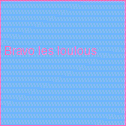

In [102]:
from io import BytesIO
from PIL import Image
from IPython.display import display

key = b'gitgud'
decFile = [f^key[i%6] for i,f in enumerate(file)]
display(Image.open(BytesIO(bytes(decFile))))

### Basics 4: Un-XOR a file 2

This time, a [WebP file](https://en.wikipedia.org/wiki/WebP) has been XOR-encrypted.

Let's repeat the process. A WebP header looks as follow:

<table style="text-align: center">
<tr><th>0x00</th><th>0x01</th><th>0x02</th><th>0x03</th><th>0x04</th><th>0x05</th><th>0x06</th><th>0x07</th></tr>
<tr><td><code>R</code></td><td><code>I</code></td><td><code>F</code></td><td><code>F</code></td><td colspan=4><i>File size</i> - 8</td></tr>
<tr><td><code>W</code></td><td><code>E</code></td><td><code>B</code></td><td><code>P</code></td><td><code>V</code></td><td><code>P</code></td><td><code>8</code></td><td>'<code> </code>'/<code>L</code>/<code>X</code></td></tr>
</table>

Since we are not sure about the 16th character, let's restrict ourself to the 15 first.

In [73]:
file = open('data/basic4.webp','br').read()
expected = list(b'RIFF----WEBPVP8')
expected[4] = (len(file)-8)&0xFF; expected[5] = (len(file)>>0o10)&0xFF; expected[6] = (len(file)>>0o20)&0xFF; expected[7] = (len(file)>>0o30)&0xFF
print('Got:      ', list(format(c,'02x') for c in file[:15]))
print('Expected: ', list(format(c,'02x') for c in expected))
print('XOR:      ', list(format(a^b,'02x') for a,b in zip(file,expected)))

Got:       ['25', '76', '30', '7b', '11', '91', '51', '61', '07', '17', '70', '1e', '3c', '00', '00']
Expected:  ['52', '49', '46', '46', '5c', 'e2', '00', '00', '57', '45', '42', '50', '56', '50', '38']
XOR:       ['77', '3f', '76', '3d', '4d', '73', '51', '61', '50', '52', '32', '4e', '6a', '50', '38']


We got a first key, `w?v=MsQaPR2NjP8`. Let's try it, and see whether we need more bytes or not.

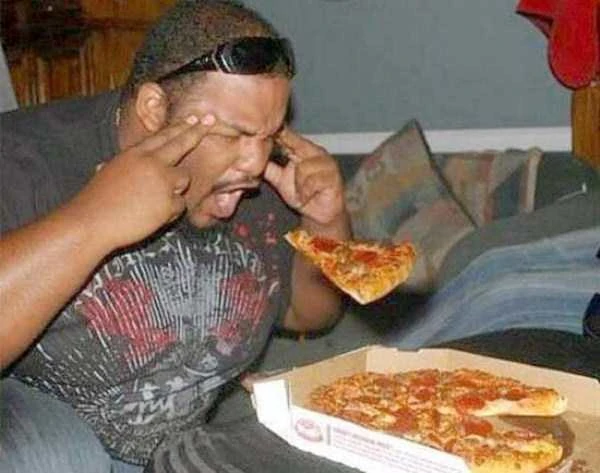

Wonderful, it works


In [74]:
key = b'w?v=MsQaPR2NjP8'
decFile = [f^key[i%15] for i,f in enumerate(file)]
try:
    display(Image.open(BytesIO(bytes(decFile))))
    print('Wonderful, it works')
except:
    print('Looks like we do need more...')

## Hash challenges

### Hash 1: Force a hash

Given the hash `37f62f1363b04df4370753037853fe88`, find the original message.

Considering the size, 16 bytes, the message was most likely hashed using the [MD5 algorithm](https://en.wikipedia.org/wiki/MD5). Forcing a hash is no easy task, but some tools can do it in our stead.

According to https://md5decrypt.net/en/, the original message was `trololo`. And indeed, hashing `trololo` returns this same hash.

### Hash 2: Confessions

If you want, you can confess anything at https://confessions.geographer.fr. You can be assured nobody will ever found... Probably... Maybe...

Well, actually, looking at the source code, I'm not so sure anymore... Even if the confessions are lost, they were first hashed using the [SHA-256 algorithm](https://en.wikipedia.org/wiki/SHA-2), and these hash are store on a [GraphQL managed database](https://en.wikipedia.org/wiki/GraphQL). Which means they can be retrieved. Moreover, it seems that they are storing them at every steps of the writing, that is for every character (¬▂¬).

Mmhhh, Aren't you curious about what's written? I sure am... Let's have a little look ( ▀¯▀)

In [4]:
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport

client = Client(transport=AIOHTTPTransport(url="https://confessions.geographer.fr/graphql"), fetch_schema_from_transport=True)
# Let's first have a look at what's available
result = await client.execute_async(gql("{ __schema { types { name fields { name description } } } }"))
print(json.dumps(result['__schema']['types'], indent=2))


[
  {
    "name": "Query",
    "fields": [
      {
        "name": "requestsLog",
        "description": "Show the resolver access log. TODO: remove before production release"
      },
      {
        "name": "confession",
        "description": "Get a confession by its hash. Does not contain confidential data."
      }
    ]
  },
  {
    "name": "Access",
    "fields": [
      {
        "name": "timestamp",
        "description": ""
      },
      {
        "name": "name",
        "description": ""
      },
      {
        "name": "args",
        "description": ""
      }
    ]
  },
  {
    "name": "String",
    "fields": null
  },
  {
    "name": "Confession",
    "fields": [
      {
        "name": "timestamp",
        "description": ""
      },
      {
        "name": "id",
        "description": ""
      },
      {
        "name": "title",
        "description": ""
      },
      {
        "name": "hash",
        "description": ""
      },
      {
        "name": "message",
      

There, the `requestsLog` seems interesting. Let's try to query them this time.

In [5]:
result = await client.execute_async(gql("{ requestsLog { timestamp name args } }"))
print(json.dumps(result['requestsLog'], indent=2))

[
  {
    "timestamp": "Thu Sep 22 2022 11:51:48 GMT+0000 (Coordinated Universal Time)",
    "name": "addConfession",
    "args": "{\"title\":\"<confidential>\",\"message\":\"<confidential>\"}"
  },
  {
    "timestamp": "Thu Sep 22 2022 11:51:48 GMT+0000 (Coordinated Universal Time)",
    "name": "confession",
    "args": "{\"hash\":\"df7e70e5021544f4834bbee64a9e3789febc4be81470df629cad6ddb03320a5c\"}"
  },
  {
    "timestamp": "Thu Sep 22 2022 11:51:49 GMT+0000 (Coordinated Universal Time)",
    "name": "addConfession",
    "args": "{\"title\":\"<confidential>\",\"message\":\"<confidential>\"}"
  },
  {
    "timestamp": "Thu Sep 22 2022 11:51:49 GMT+0000 (Coordinated Universal Time)",
    "name": "confession",
    "args": "{\"hash\":\"567d6942cf5211b4321ec51929f02f900a56260d92e6df24be91c909dedd8adb\"}"
  },
  {
    "timestamp": "Thu Sep 22 2022 11:51:50 GMT+0000 (Coordinated Universal Time)",
    "name": "addConfession",
    "args": "{\"title\":\"<confidential>\",\"message\":\"<confid

Mmmh, looks like there is always two simultaneous operations: `addConfession` and `confession`. And this second one has the hash.

Moreover, the message are very close in time. In fact, it's so close it can't be a coincidence. And you know what, a deeper look at the source code shows that these operations are effectued after every single character!

Now it will be so much easier to read a message (¬‿¬)

In [6]:
result = [req for req in result['requestsLog'] if req['name'] == 'confession']
s = b''
for l,req in enumerate(result[:3]):
    if req['args'] == '{}': break # Empty message
    hash = json.loads(req['args'])['hash']
    # Let's try every characters
    for i in range(256):
        c = chr(i).encode()
        if sha256(s+c).hexdigest() == hash:
            s += c
            break
    print(hash, s)
    # We fail to find the character, let's stop
    if len(s) != l+1:
        print('error')
        break
print('Here a confession: ' + s.decode())

df7e70e5021544f4834bbee64a9e3789febc4be81470df629cad6ddb03320a5c b'B'
567d6942cf5211b4321ec51929f02f900a56260d92e6df24be91c909dedd8adb b'BF'
d977af2aeb54b20524848814f0875ea14ba33357ba2830ad284ee20e4430c192 b'BFS'
Here a confession: BFS


## Symmetric challenges

### Symmetric 1: Retrieve an IV

The IV used for our [AES cipher](https://en.wikipedia.org/wiki/Advanced_Encryption_Standard) has been lost. Retrieve it using a pair of plain and cipher text. But be careful, the pair has been corrupted!

We know the cipher is an AES cipher in CBC mode, using the key `omgwtfbbq`. We also know that `I was lost, but ----------------` was encrypted as `\x--\xf3\x74\xa8\x2d\xb5\x0b\x23\x--\x--\x-b\x88\xf1\xd9\x76\xdd\xc1\xcf\x6d\xb4\x52\x4a\xac\x04\xe2\x22\x85\x39\x69\x36\x7e\x0d`, where `-` represent corrupted data.

![Encryption](https://upload.wikimedia.org/wikipedia/commons/d/d3/Cbc_encryption.png)

In order to retrieve the IV, we first need to restore the plain and cipher texts. AES ciphers use 16-bytes blocks. Since both texts are 32 bytes long, we have two blocks. 

In [106]:
from Crypto.Cipher import AES

key = sha256(b'omgwtfbbq').digest()
plain1 = b'I was lost, but '
# Unkown bytes are replaced by 0x00
plain2 = b'\x00'*16
enc1 = b'\x00\xf3\x74\xa8\x2d\xb5\x0b\x23\x00\x00\x0b\x88\xf1\xd9\x76\xdd'
enc2 = b'\xc1\xcf\x6d\xb4\x52\x4a\xac\x04\xe2\x22\x85\x39\x69\x36\x7e\x0d'

Advancing step by step, we first need to fix the second plain block, which will allow us to fix the first cipher block, which will eventually allow us to find the IV.

In [116]:
# The IV for the second block is the first encrypted block
cipher = AES.new(key, AES.MODE_CBC, iv=enc1)
plain2 = cipher.decrypt(enc2)
print(bytes([c if i not in (0,8,9,10) else 0 for i,c in enumerate(plain2)]))

b"\x00ow I'm \x00\x00\x00nd..."


Alright, the second plain text seems to be `-ow I'm ---nd...`. After a bit of brainstorming and tests (which I will spare you), we discovered that the complete plain text was `I was lost, but now I'm found...`. We can now fix the first cipher block.

In [127]:
plain2 = b"now I'm found..."
# We know the plain text, we want the IV, so we invert the two
cipher = AES.new(key, AES.MODE_CBC, iv=plain2)
enc1 = cipher.decrypt(enc2)
print(''.join(f'\\x{c:02x}' for c in enc1))

\x02\xf3\x74\xa8\x2d\xb5\x0b\x23\xa7\xd0\x9b\x88\xf1\xd9\x76\xdd


We have the first block of both plain and cipher texts, so now it's time to find the IV.

In [128]:
cipher = AES.new(key, AES.MODE_CBC, iv=plain1)
iv = cipher.decrypt(enc1)
print(iv)

b'h4ppyh4ppya5canB'


### Symmetric 2: Bit-flip

I found a site, https://flip1.geographer.fr, which seems to be easy to log into with an admin account. Do you want to try?

Look, there is a cookie, named `cookie`, which contains your username, password and admin right. Well, of course, this cookie is encrypted, but...

Here's the cookie `Q01pZXV4VW5JVlJhbmRvbbBNVUWTyb3i9ih6TPY9Ovq0YRsnNe8ulLlQSq6hvr3S8rtyevLBdsTPlUi4Z0qkyw==`, which is base64 encoded. The decoded version is `CMieuxUnIVRandom\xb0\x4d\x55\x45\x93\xc9\xbd\xe2\xf6\x28\x7a\x4c\xf6\x3d\x3a\xfa\xb4\x61\x1b\x27\x35\xef\x2e\x94\xb9\x50\x4a\xae\xa1\xbe\xbd\xd2\xf2\xbb\x72\x7a\xf2\xc1\x76\xc4\xcf\x95\x48\xb8\x67\x4a\xa4\xcb`. According to the site, it should be decrypted as `{'admin': 0, 'password': '', 'username': ''}`. So, the plain text is 44 bytes long, the cipher text, 64. Well, since the 16 first bytes are the IV (according to what's written, that is), it's 48 bytes long. Seems about right.

So, we have an unknown encryption algorithm, with an unknown key, but a known IV, plain and cipher texts. Well, since we have a 16-bytes long IV, we can assume it's use 16 bytes long blocks. Let's try to change the cookie so that the `admin` field is set at `1`.

Well, if we assume the encryption algorithm is once again an AES cipher in CBC mode, we know that the cipher text is decrypted, and then XORed with the IV. So if we want to change our `0` into a `1`, we just need to change a byte on the IV, which will then be propagated on the plain text thanks to the XOR operation.

In [158]:
from html import unescape

baseIV = list(b'CMieuxUnIVRandom')
cipher = b'\xb0\x4d\x55\x45\x93\xc9\xbd\xe2\xf6\x28\x7a\x4c\xf6\x3d\x3a\xfa\xb4\x61\x1b\x27\x35\xef\x2e\x94\xb9\x50\x4a\xae\xa1\xbe\xbd\xd2\xf2\xbb\x72\x7a\xf2\xc1\x76\xc4\xcf\x95\x48\xb8\x67\x4a\xa4\xcb'

# We want the bits necessary to change a 0 into a 1
baseIV[10] ^= ord('0') ^ ord('1')
cookie = b64encode(bytes(baseIV) + cipher).decode()
print('Cookie: ' + cookie)

result = requests.get('https://flip1.geographer.fr/flag', cookies={
    'cookie': cookie
})
m = re.findall(r'<div class="jumbotron">\s+(.+?)\s+</div>', result.text, re.DOTALL)
print('Output:\n\t'+'\n\t'.join([unescape(re.sub('\s*<.+?>\s*', '', s)) for s in m]))

Cookie: Q01pZXV4VW5JVlNhbmRvbbBNVUWTyb3i9ih6TPY9Ovq0YRsnNe8ulLlQSq6hvr3S8rtyevLBdsTPlUi4Z0qkyw==
Output:
	Congratz Admin ! Here iz ur flag ;)
	BFS{3ll3_S0n1_0u_lé_P1l_v1t3_v1t3_1_H4V_N33D5!}


### Symmetric 3: Bit-flip 2

You liked the previous site? Because I found a new one, https://flip1.geographer.fr, ready for you to hack (▀¯▀ ).

Here some basic informations:
* Plain cookie: `{'password': '', 'username': '', 'admin': 0}`
* Encrypted cookie: `ly5Fcc+qQYMvzti1hrXc06B/zc+iHyTkply2FPfh6QQkSWEn2c/XQsqtHUPw6LWTIZ0n5Tcl8fVbYHXe13PX9w==`
* Base64 decoded: `\x97\x2e\x45\x71\xcf\xaa\x41\x83\x2f\xce\xd8\xb5\x86\xb5\xdc\xd3\xa0\x7f\xcd\xcf\xa2\x1f\x24\xe4\xa6\x5c\xb6\x14\xf7\xe1\xe9\x04\x24\x49\x61\x27\xd9\xcf\xd7\x42\xca\xad\x1d\x43\xf0\xe8\xb5\x93\x21\x9d\x27\xe5\x37\x25\xf1\xf5\x5b\x60\x75\xde\xd7\x73\xd7\xf7`

So, first our encrypted cookie is once again 64 bytes, so we have an IV (even if it is random this time). However, we won't be able to do the same as before. Indeed, the `admin` field is in the last block, so changing the IV will not be enough. Should we try changing the previous block, similarly to before?

In [213]:
IV = list(b'\x97\x2e\x45\x71\xcf\xaa\x41\x83\x2f\xce\xd8\xb5\x86\xb5\xdc\xd3')
cipher = list(b'\xa0\x7f\xcd\xcf\xa2\x1f\x24\xe4\xa6\x5c\xb6\x14\xf7\xe1\xe9\x04\x24\x49\x61\x27\xd9\xcf\xd7\x42\xca\xad\x1d\x43\xf0\xe8\xb5\x93\x21\x9d\x27\xe5\x37\x25\xf1\xf5\x5b\x60\x75\xde\xd7\x73\xd7\xf7')
plain = list(b"{'password': '', 'username': '', 'admin': 0}")

def bitFlip2(iv, cipher):
    result = requests.get('https://flip2.geographer.fr/flag', cookies={
        "cookie": b64encode(bytes(iv+cipher)).decode()
    })
    m = re.search(r'<div class="alert alert-danger.*?/button>\s*(.*?)\s*</div>', result.text, re.DOTALL)
    if m:
        print('Error:\n\t' + unescape(m[1]))
    else:
        m = re.findall(r'<div class="jumbotron">\s+(.+?)\s+</div>', result.text, re.DOTALL)
        print('Output:\n\t'+'\n\t'.join([unescape(re.sub('\s*<.+?>\s*', '', s)) for s in m]))

In [214]:
# First a basic test, to show it works
bitFlip2(IV, cipher)

Output:
	No flag for you
	Cookie: {'password': '', 'username': '', 'admin': 0}


In [215]:
# Let's try to change the 0 into 1
cipher[42-16] ^= ord('0') ^ ord('1')
bitFlip2(IV, cipher)
cipher[42-16] ^= ord('0') ^ ord('1')

Error:
	'utf-8' codec can't decode byte 0x84 in position 16: invalid start byte


Ok, change of plan, let's try to write `admin` at the beginning, then use the IV as we know howto.

In [216]:
bitFlip2([k^p^c for k,p,c in zip(IV,plain[:16],b"{'admin   ': '',")], cipher)

Output:
	No flag for you
	Cookie: {'admin   ': '', 'username': '', 'admin': 0}


In [217]:
# Let's try to write admin now
bitFlip2([k^p^c for k,p,c in zip(IV,plain[:16],b"{'admin':     1,")], cipher)

Error:
	Expecting ':' delimiter: line 1 column 19 (char 18)


Oh, something wrong... What can it be?

In [218]:
# Let's try to put a single quote
bitFlip2([k^p^c for k,p,c in zip(IV,plain[:16],b"{'passw'rd': '',")], cipher)

Output:
	No flag for you
	Cookie: {"passw'rd": '', 'username': '', 'admin': 0}


In [219]:
# What about a double quote
bitFlip2([k^p^c for k,p,c in zip(IV,plain[:16],b"{'passw\"rd': '',")], cipher)

Error:
	Expecting ':' delimiter: line 1 column 9 (char 8)


Oh, it's expecting a colon right after my double quote! Could it be...

In [220]:
# Let's replace every single quote with double ones
bitFlip2([k^p^c for k,p,c in zip(IV,plain[:16],b'{"password": "",')], cipher)

Error:
	Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


That was that! It actually doesn't use simple quote `'`, but double quote `"`!

In [223]:
plain = list(b'{"password": "", "username": "", "admin": 0}')
bitFlip2([k^p^c for k,p,c in zip(IV,plain[:16],b'{"admin":     1,')], cipher)

Output:
	No flag for you
	Cookie: {'admin': 0, 'username': ''}


Now, I have my `admin` at the beginning, like before. But it is overriden by the second one. I need to remove it.

In [224]:
bitFlip2([k^p^c for k,p,c in zip(IV,plain[:16],b'{"admin":     1}')], cipher[:16])

Error:
	Expecting value: line 1 column 1 (char 0)


Oh, another error... Not very useful again... Maybe it's some padding errors?

In [222]:
from Crypto.Util.Padding import pad
bitFlip2([k^p^c for k,p,c in zip(IV,plain[:16],pad(b'{"admin": 1}',16))], cipher[:16])

Output:
	Congratz Admin ! Here iz ur flag ;)
	BFS{Tr0_F4ss1l_a3s_enc0r_D_C00ki}


## RSA challenges

### RSA 1: Create a private key

Given a [public key](https://en.wikipedia.org/wiki/Public-key_cryptography) and one of the number used to create the modulus, create a private key, and decipher the message.

The public key is availablat at [/data/rsa1.pem](/data/rsa1.pem), and the encrypted message at [/data/rsa1Cipher.txt](/data/rsa1Cipher.txt). Also, the number is `11901234461494228310064076121482038286429650089208969229876184007349956782094248940290427800597817633601014470221576037327691902428151823981665392121868907`. By the way, the message was encrypted using the [PKCS1 OAEP](https://en.wikipedia.org/wiki/Optimal_asymmetric_encryption_padding) algorithm.

Here's a little remainder:
* A public key is composed of two elements:
  * A number $e$ used for encryption
  * The modulus $N$
* A private key is composed of two elements:
  * A number $d$ used for decryption
  * The modulus $N$
* $N = pq$
* $ed\mod \phi(N) = 1$
* If $p$ and $q$ are both prime numbers, $\phi(pq) = (p-1)(q-1)$

In [229]:
from Crypto.Cipher import PKCS1_OAEP

enc = open('data/rsa1Cipher.txt','br').read()
key = RSA.import_key(open('data/rsa1.pem').read())
p = 11901234461494228310064076121482038286429650089208969229876184007349956782094248940290427800597817633601014470221576037327691902428151823981665392121868907

# d = e^-1 mod phi(n)
d = pow(key.e, -1, (p-1)*(key.n//p-1))
key2 = RSA.construct((key.n, key.e, d))
cipher = PKCS1_OAEP.new(key2)
print(cipher.decrypt(enc))

b'[Good job! Next chall: /rsa2ez4me.zip]'


### RSA 2: Many keys

Given 101 public keys and an encrypted message, decrypt it.

The keys are available at [/data/rsa2/keys/](/data/rsa2/keys/), and the message at [/data/rsa2/cipher.txt](/data/rsa2/cipher.txt).

So, the question now is, what do we do?

I'll tell you, because I try it, but re-encrypt the message with one of the key does not work, neither does encrypting it with every keys.

So what? We have 101 keys, meaning 101 `e` and `N`. Maybe some keys use a common `p` or `q`? Let's check it out.

In [234]:
from math import gcd

enc = open('data/rsa2/cipher.txt','br').read()
keys = [RSA.import_key(open(f'data/rsa2/keys/pub{i}.pem','r').read()) for i in range(101)]    

for i in range(100):
    for j in range(i+1,101):
        cd = gcd(keys[i].n,keys[j].n)
        if cd != 1:
            print(i,j)

64 100


Oh, there it is! The 65th and 101st keys have a common divisor. So we can recreate the private keys associated!

In [239]:
n1 = keys[64].n
n2 = keys[100].n
e1 = keys[64].e
e2 = keys[100].e
p = gcd(n1, n2)
q1 = n1 // p
q2 = n2 // p

key1 = RSA.construct((n1, e1, pow(e1, -1, (p-1)*(q1-1))))
key2 = RSA.construct((n2, e2, pow(e2, -1, (p-1)*(q2-1))))

# For the algorithm, let's try the same as before
try:
    plain = PKCS1_OAEP.new(key1).decrypt(enc)
    print(plain)
except:
    print('It\'s not the 65th key...')
try:
    plain = PKCS1_OAEP.new(key2).decrypt(enc)
    print(plain)
except:
    print('It\s not the 101st key...')

It's not the 65th key...
b'Shared prime factors?! Impossible... Or improbable? ;)'


### RSA 3: Multiple encryption

A same message hsa been encrypted with different keys. Find the original message.

Your lucky, we know what is the encryption algorithm. They generate a pair of key with an `e` equal to `3` and two `p` and `q` as two prime numbers of 256 bits. What's more, their encryption algorithm is a simple $M^e \mod N$.

Ever heard of the Chinese Remainder Theorem? Well it will allow you to solve this problem. Good luck!

$$
M^3 \equiv C_i \mod N_i \\
--------- \\
N = \prod N_k \\
\overline{N_i} = N/N_i \\
y_i \equiv (\overline{N_i})^{-1} \mod N_i \\
--------- \\
M^3 \equiv \sum C_k\overline{N_k}y_k \mod N
$$

In [245]:
from math import prod

# https://gist.github.com/jl4730/47c6c88bef60ac35b9da961dc424fe82
def find_invpow(x,n):
    """Finds the integer component of the n'th root of x,
    an integer such that y ** n <= x < (y + 1) ** n.
    """
    high = 1
    while high ** n < x:
        high *= 2
    low = high//2
    while low < high:
        mid = (low + high) // 2
        if low < mid and mid**n < x:
            low = mid
        elif high > mid and mid**n > x:
            high = mid
        else:
            return mid
    return mid + 1

In [246]:
Cs = [int(open(f'data/rsa3/cipherDumps/cipher{i}.txt','r').read()) for i in range(3)]
keys = [RSA.import_key(open(f'data/rsa3/cipherDumps/pubkey{i}.pem','r').read()) for i in range(3)]

N = prod([key.n for key in keys])
_N_s = [N // key.n for key in keys]
ys = [pow(_N_, -1, key.n) for _N_,key in zip(_N_s,keys)]

M3 = sum([Cs[k]*_N_s[k]*ys[k] for k in range(3)]) % N
M = find_invpow(M3, 3)

# Basic 2, but one-lined
plain = ''.join([chr(int(c,16)) for c in re.findall(r'..', f'{M:02x}')])
print(plain)

f*ck the world & be real cool


## Flags

Base2: `Well done ! The flag for this challenge is this message.`<br>
Base3: `gitgud`<br>
Base4: `w?v=MsQaPR2NjP8`<br>
Hash1: `trololo`<br>
Hash2: `BFS{plz_d0nt_t3ll_any1}`<br>
Sym1:  `h4ppyh4ppya5canB`<br>
Sym2:  `BFS{3ll3_S0n1_0u_lé_P1l_v1t3_v1t3_1_H4V_N33D5!}`<br>
Sym3:  `BFS{Tr0_F4ss1l_a3s_enc0r_D_C00ki}`<br>
RSA1:  `[Good job! Next chall: /rsa2ez4me.zip]`<br>
RSA2:  `Shared prime factors?! Impossible... Or improbable? ;)`<br>
RSA3:  `f*ck the world & be real cool`<br>